In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('~/Python_Tool/ryan_mplstyle.mplstyle')

import numpy as np

import cmocean.cm as cmo
import dedalus.public as d3
from scipy.stats import skew

import sys
sys.path.insert(0, '../../subroutines')
from isospectrum import isospectrum

In [2]:
Ro = 0.032
nun2 = 3

dgname = 'EadyQGPl_dg_%.3f_%d/EadyQGPl_dg_%.3f_%d_s%i' %(Ro, nun2, Ro, nun2, 1)
dgname = dgname.replace(".", "d" ); dgname = "../"+dgname+'.h5'

with h5py.File(dgname, mode='r') as file:
    KE_data = np.squeeze(np.array(file['tasks']['KE']))
    PE_data = np.squeeze(np.array(file['tasks']['PE']))
    avgbt_data = np.squeeze(np.array(file['tasks']['avgbt']))
    avgbb_data = np.squeeze(np.array(file['tasks']['avgbb']))
    
    dg_time_ary = np.array(file['scales']['sim_time'])
    print(dg_time_ary[-10:-1])

spname = 'EadyQGPl_sp_%.3f_%d/EadyQGPl_sp_%.3f_%d_s%i' %(Ro, nun2, Ro, nun2, int((dg_time_ary[-1]-1)/10+1)-0 )
# spname = 'EadyQGPl_sp_%.2f_%.2f/EadyQGPl_sp_%.2f_%.2f_s%i' %(Ro, nun2, Ro, nun2, 1 )
spname = spname.replace(".", "d" ); spname = "../"+spname+'.h5'

with h5py.File(spname, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))
    
print(spname)

[198.99866914 199.10073773 199.20065131 199.29987792 199.40125036
 199.4988012  199.60126648 199.70123161 199.80018468]
['scales', 'tasks']
<HDF5 group "/scales" (9 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number', 'x_hash_7cca60416d779fd913c1a86e88754613c4f264c4', 'y_hash_7cca60416d779fd913c1a86e88754613c4f264c4', 'z_hash_c15d9d42c8358761910dd56e7041f198d841a147']
<HDF5 group "/tasks" (14 members)>
['P0_yslc', 'P0_zslc', 'P1_yslc', 'P1_zslc', 'b_bot', 'b_mm', 'b_mt', 'b_top', 'div_bot', 'div_top', 'strain_bot', 'strain_top', 'zeta_bot', 'zeta_top']
../EadyQGPl_sp_0d032_3/EadyQGPl_sp_0d032_3_s20.h5


In [3]:
bt_all = np.empty([0,512,512])
bb_all = np.empty([0,512,512])
bmt_all = np.empty([0,512,512])
bmm_all = np.empty([0,512,512])

zetat_all = np.empty([0,512,512])
zetab_all = np.empty([0,512,512])
zetamt_all = np.empty([0,512,512])
zetamm_all = np.empty([0,512,512])

straint_all = np.empty([0,512,512])
div_all = np.empty([0,512,512])

for di in range(16,21):
    print(di)
    
    spname = 'EadyQGPl_sp_%.3f_%d/EadyQGPl_sp_%.3f_%d_s%i' %(Ro, nun2, Ro, nun2, di )
    spname = spname.replace(".", "d" ); spname = "../"+spname+'.h5'

    # Plot writes
    with h5py.File(spname, mode='r') as file:
        bt_data = np.squeeze(np.array(file['tasks']['b_top']))
        bb_data = np.squeeze(np.array(file['tasks']['b_bot']))
#         bmt_data = np.squeeze(np.array(file['tasks']['b_mt']))
#         bmm_data = np.squeeze(np.array(file['tasks']['b_mm']))

        zetat_data = np.squeeze(np.array(file['tasks']['zeta_top']))*0.06
#         zetamt_data = np.squeeze(np.array(file['tasks']['zeta_mt']))*0.06
#         zetamm_data = np.squeeze(np.array(file['tasks']['zeta_mm']))*0.06
        zetab_data = np.squeeze(np.array(file['tasks']['zeta_bot']))*0.06
        
        divt_data = np.squeeze(np.array(file['tasks']['div_top']))*0.06
        straint_data = np.squeeze(np.array(file['tasks']['strain_top']))*0.06
        
        ####
        bt_all = np.append(bt_all,bt_data,axis=0)
        bb_all = np.append(bb_all,bb_data,axis=0)
#         bmt_all = np.append(bmt_all,bmt_data,axis=0)
#         bmm_all = np.append(bmm_all,bmm_data,axis=0)
        
        zetat_all = np.append(zetat_all,zetat_data,axis=0)
        zetab_all = np.append(zetab_all,zetab_data,axis=0)
#         zetamt_all = np.append(zetamt_all,zetamt_data,axis=0)
#         zetamm_all = np.append(zetamm_all,zetamm_data,axis=0)
        
        straint_all = np.append(straint_all,straint_data,axis=0)
        div_all = np.append(div_all,divt_data,axis=0)

16
17
18
19
20


In [4]:
# fig=plt.figure(figsize=(2.8, 2.0))

# plt.hist(zetat_all[:,:,:].ravel(), log=True, density=True, bins=50, histtype='step',  label="$\zeta^t/f$, %.2f" %skew(zetat_all[:,:,:].ravel()))
# # plt.hist(zetab_all[:,:,:].ravel(), log=True, density=True, bins=50, histtype='step',  label="$\zeta^b/f$, %.2f" %skew(zetab_all[:,:,:].ravel()))
# # plt.hist(zetamt_all[:,:,:].ravel()*4, log=True, density=True, bins=50, histtype='step', label=r"$4\times\zeta(z=-H/4)/f$, %.2f" %skew(zetamt_all[:,:,:].ravel()))
# # plt.hist(zetamm_all[:,:,:].ravel()*4, log=True, density=True, bins=50, histtype='step', label=r"$4\times\zeta(z=-H/2)/f$, %.2f" %skew(zetamm_all[:,:,:].ravel()))

# # plt.title('$\epsilon=%.2f$' %Ro)
# # plt.xlabel("$\zeta/f$")
# plt.xlim([-5,12])
# plt.xlabel("$\zeta/f$")

# legend = plt.legend(title="Values, Skewness", fontsize=7)
# plt.setp(legend.get_title(),fontsize=8)

# figname = 'figs/EadyQGpl_zetaPDFs_Ro%.2f' %(Ro)
# figname = figname.replace(".", "d" ); figname = figname+'.pdf'
# plt.savefig(figname, bbox_inches='tight')
# plt.show()

In [5]:
zmax = np.max(zetat_all[:,:,:].ravel())+1e-10
zmin = np.min(zetat_all[:,:,:].ravel())

z_range = np.linspace(zmin,zmax,50)
s_range = np.arange(0,zmax,z_range[-1]-z_range[-2])

print(z_range.shape)

(50,)


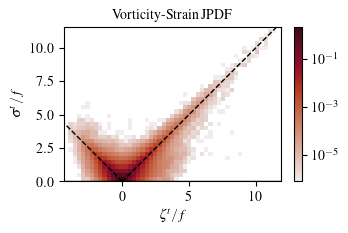

In [6]:
fig=plt.figure(figsize=(3.5, 2.0))

plt.hist2d(zetat_all[:,:,:].ravel(),straint_all[:,:,:].ravel(), density=True, bins=[z_range, s_range], cmap=cmo.amp, norm=colors.LogNorm())
axs_max = max(abs(zetat_all[:,:,:].ravel()))
# axs_max = 3.5
plt.plot([0,axs_max],[0,axs_max],'--',color='k'); plt.plot([0,-axs_max],[0,axs_max],'--',color='k'); plt.axhline(0,color='k')
plt.axis('equal'); 
plt.xlim(min(zetat_all[:,:,:].ravel()),max(zetat_all[:,:,:].ravel()))
plt.colorbar()
plt.title('Vorticity-Strain JPDF')
plt.xlabel("$\zeta^t/f$")
plt.ylabel("$\sigma^t/f$")

figname = 'figs/EadyQGpl_jointPDFs_Ro%.2f' %(Ro)
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
plt.savefig(figname, bbox_inches='tight')

plt.show()

In [7]:
za = zetat_all[:,:,:].ravel()
sa = straint_all[:,:,:].ravel()
da = div_all[:,:,:].ravel()

div_mean = np.empty((z_range.size-1,s_range.size-1))

for z_i in range(z_range.size-1):
    for s_i in range(s_range.size-1):
        z_here = (za>=z_range[z_i])*(za<z_range[z_i+1])
        s_here = (sa>=s_range[s_i])*(sa<s_range[s_i+1])
        
        div_mean[z_i,s_i] = np.mean(da[z_here*s_here])

/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


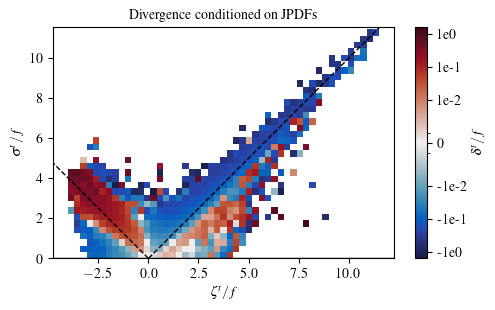

In [8]:
fig=plt.figure(figsize=(5.5, 3))

# plt.pcolor((z_range[1:]+z_range[:-1])/2,(s_range[1:]+s_range[:-1])/2,div_mean.T, cmap=cmo.balance, norm=colors.CenteredNorm())
cax = plt.pcolormesh((z_range[1:]+z_range[:-1])/2,(s_range[1:]+s_range[:-1])/2,\
           div_mean.T, cmap=cmo.balance, norm=colors.SymLogNorm(linthresh=5e-4, linscale=1e-2,vmin=(np.nanmin(div_mean)),vmax=-(np.nanmin(div_mean))))

plt.plot([0,axs_max],[0,axs_max],'--',color='k'); plt.plot([0,-axs_max],[0,axs_max],'--',color='k'); plt.axhline(0,color='k')
plt.axis('equal'); plt.xlim(min(zetat_all[:,:,:].ravel()),max(zetat_all[:,:,:].ravel()))

cbar = fig.colorbar(cax, ticks=[-1e-2,-1e-1,-1e-0, 1e-0, 1e-1, 1e-2, 0])
cbar.ax.set_yticklabels(['-1e-2','-1e-1', '-1e0', '1e0', '1e-1', '1e-2', '0'])  # vertically oriented colorbar

plt.title('Divergence conditioned on JPDFs')
plt.xlabel("$\zeta^t/f$")
plt.ylabel("$\sigma^t/f$")
cbar.set_label('$\delta^t/f$')

figname = 'figs/EadyQGpl_condJPDF_Ro%.2f' %(Ro)
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
plt.savefig(figname, bbox_inches='tight')

plt.show()

### 